In [29]:
import pandas as pd
import datetime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import geopandas as gpd
import os
from rasterio.mask import mask
from rasterio.plot import show

## Length of growing period (LGP)

In [20]:
districts = gpd.read_file('./Data/district.shp')

# set CRS
districts = districts.set_crs(epsg=4326)

input_dir = './FAO'

output_dir = './FAO/clipped'
os.makedirs(output_dir, exist_ok=True)

# loop to clip raster for each year
for year in range(2000, 2022):
    input_path = os.path.join(input_dir, f'lgp_{year}.tif')
    output_path = os.path.join(output_dir, f'lgp_{year}_clipped.tif')
    with rasterio.open(input_path) as src:
        geometries = [feature['geometry'] for feature in districts.__geo_interface__['features']]
        clipped_raster, clipped_transform = mask(src, geometries, crop=True)
        clipped_meta = src.meta.copy()
    
    clipped_meta.update({
        'height': clipped_raster.shape[1],
        'width': clipped_raster.shape[2],
        'transform': clipped_transform
    })

    # save clipped raster to new file
    with rasterio.open(output_path, 'w', **clipped_meta) as dst:
        dst.write(clipped_raster)

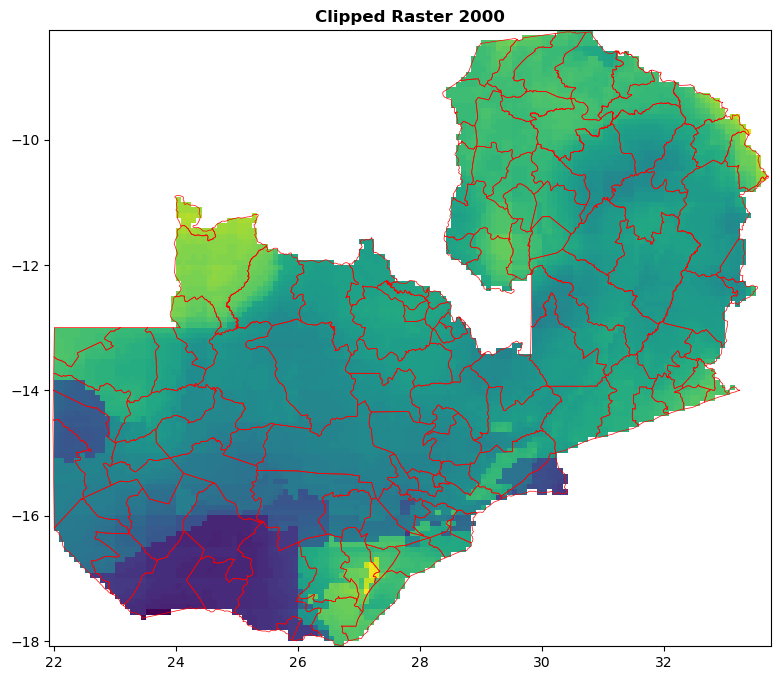

In [18]:
# plot raster with district overlay
with rasterio.open('./FAO/lgp_2000_clipped.tif') as src:
    fig, ax = plt.subplots(figsize=(10, 8))
    show(src, ax=ax, cmap='viridis', title='Clipped Raster 2000')
    districts.boundary.plot(ax=ax, color='red', linewidth=0.5)
    plt.show()

### Compute means

In [23]:
district_name = 'NAME_2'

input_dir = './FAO/clipped'

# empty list to store results
results = []

for year in range(2000, 2022):
    raster_path = os.path.join(input_dir, f'lgp_{year}_clipped.tif')
    if not os.path.exists(raster_path):
        print(f'file missing for {year}, skipping')
        continue

    with rasterio.open(raster_path) as src:
        for idx, row in districts.iterrows():
            geom = [row['geometry']]
            try:
                out_image, _ = mask(src, geom, crop=True)
                values = out_image[0]
                # mask out invalid values
                values = np.where(values < 0, np.nan, values)
                mean_val = np.nanmean(values)
            except Exception as e:
                print(f'Error on district {row[district_name]} ({year}): {e}')
                mean_val = np.nan

            results.append({
                'district': row[district_name],
                'year': year,
                'mean_growing_period': mean_val
            })

# save results to CSV
df = pd.DataFrame(results)
df.to_csv('district_growing_periods.csv', index=False)


## Beginning date of LGP

In [24]:
# clip data to district-level
input_dir = './FAO'

output_dir = './FAO/clipped'
os.makedirs(output_dir, exist_ok=True)

# loop to clip raster for each year
for year in range(2000, 2022):
    input_path = os.path.join(input_dir, f'lgb_{year}.tif')
    output_path = os.path.join(output_dir, f'lgb_{year}_clipped.tif')
    with rasterio.open(input_path) as src:
        geometries = [feature['geometry'] for feature in districts.__geo_interface__['features']]
        clipped_raster, clipped_transform = mask(src, geometries, crop=True)
        clipped_meta = src.meta.copy()
    
    clipped_meta.update({
        'height': clipped_raster.shape[1],
        'width': clipped_raster.shape[2],
        'transform': clipped_transform
    })

    # save clipped raster to new file
    with rasterio.open(output_path, 'w', **clipped_meta) as dst:
        dst.write(clipped_raster)

In [25]:
district_name = 'NAME_2'

input_dir = './FAO/clipped'

# empty list to store results
results = []

for year in range(2000, 2022):
    raster_path = os.path.join(input_dir, f'lgb_{year}_clipped.tif')
    if not os.path.exists(raster_path):
        print(f'file missing for {year}, skipping')
        continue

    with rasterio.open(raster_path) as src:
        for idx, row in districts.iterrows():
            geom = [row['geometry']]
            try:
                out_image, _ = mask(src, geom, crop=True)
                values = out_image[0]
                # mask out invalid values
                values = np.where(values < 0, np.nan, values)
                mean_val = np.nanmean(values)
            except Exception as e:
                print(f'Error on district {row[district_name]} ({year}): {e}')
                mean_val = np.nan

            results.append({
                'district': row[district_name],
                'year': year,
                'mean_start_day': mean_val
            })

# save results to CSV
df = pd.DataFrame(results)
df.to_csv('growing_season_start.csv', index=False)

### Convert Julian dates

In [30]:
df = pd.read_csv('./FAO/growing_season_start.csv')

base_year = 2001 # 2000 was a leap year
df['start_date'] = df['mean_start_day'].apply(
    lambda d: (datetime(base_year, 1, 1) + timedelta(days=int(d - 1))).strftime('%B %d')if pd.notnull(d) else None
)

df.to_csv('growing_season_start_dates.csv', index=False)

### Merge dataframes

In [31]:
start_dates = pd.read_csv('./FAO/growing_season_start_dates.csv')
growing_periods = pd.read_csv('./FAO/district_growing_periods.csv')

# merge on district and year
merged = pd.merge(start_dates, growing_periods, on=['district', 'year'], how='inner')

# drop redundant column
merged = merged.drop(columns=['mean_start_day'])

# save to CSV
merged.to_csv('growing_season_district.csv', index=False)